In [1]:
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk import word_tokenize
from nltk.corpus import conll2000 as cl
from nltk.corpus import brown as br

import pprint

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
tagged_sentences = cl.tagged_sents(tagset = 'universal') + br.tagged_sents(tagset = 'universal') 

pprint.pprint(tagged_sentences[0])
print(len(tagged_sentences))

[('Confidence', 'NOUN'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('pound', 'NOUN'),
 ('is', 'VERB'),
 ('widely', 'ADV'),
 ('expected', 'VERB'),
 ('to', 'PRT'),
 ('take', 'VERB'),
 ('another', 'DET'),
 ('sharp', 'ADJ'),
 ('dive', 'NOUN'),
 ('if', 'ADP'),
 ('trade', 'NOUN'),
 ('figures', 'NOUN'),
 ('for', 'ADP'),
 ('September', 'NOUN'),
 (',', '.'),
 ('due', 'ADJ'),
 ('for', 'ADP'),
 ('release', 'NOUN'),
 ('tomorrow', 'NOUN'),
 (',', '.'),
 ('fail', 'VERB'),
 ('to', 'PRT'),
 ('show', 'VERB'),
 ('a', 'DET'),
 ('substantial', 'ADJ'),
 ('improvement', 'NOUN'),
 ('from', 'ADP'),
 ('July', 'NOUN'),
 ('and', 'CONJ'),
 ('August', 'NOUN'),
 ("'s", 'PRT'),
 ('near-record', 'ADJ'),
 ('deficits', 'NOUN'),
 ('.', '.')]
68288


In [3]:
def untag_sentences(tagged_sentences):
    X = [] # store input sequence
    Y = [] # store output sequence
    
    for sentence in tagged_sentences:
        X_sentence = []
        Y_sentence = []
        for entity in sentence:         
            X_sentence.append(entity[0])  # entity[0] contains the word
            Y_sentence.append(entity[1])  # entity[1] contains corresponding tag

        X.append(X_sentence)
        Y.append(Y_sentence)
    
    num_words = len(set([word.lower() for sentence in X for word in sentence]))
    num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

    print(set([word for sentence in Y for word in sentence]))
    print("Total number of tagged sentences: {}".format(len(X)))
    print("Vocabulary size: {}".format(num_words))
    print("Total number of tags: {}".format(num_tags))
    
    return X, Y

In [4]:
X, Y = untag_sentences(tagged_sentences)

{'ADP', 'ADJ', 'CONJ', 'PRON', 'ADV', 'PRT', 'DET', '.', 'NUM', 'X', 'VERB', 'NOUN'}
Total number of tagged sentences: 68288
Vocabulary size: 56952
Total number of tags: 12


In [5]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

sample X:  ['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits', '.'] 

sample Y:  ['NOUN', 'ADP', 'DET', 'NOUN', 'VERB', 'ADV', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.', 'ADJ', 'ADP', 'NOUN', 'NOUN', '.', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'CONJ', 'NOUN', 'PRT', 'ADJ', 'NOUN', '.'] 

Length of first input sequence  : 37
Length of first output sequence : 37


In [6]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
TAGS = {v: k for k, v in tag_tokenizer.word_index.items()}
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [7]:
pprint.pprint(TAGS)

{1: 'noun',
 2: 'verb',
 3: '.',
 4: 'adp',
 5: 'det',
 6: 'adj',
 7: 'adv',
 8: 'pron',
 9: 'conj',
 10: 'prt',
 11: 'num',
 12: 'x'}


In [8]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')

print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')
print('length X encoded: ', len(X_encoded[0]), '\n')
print('length Y encoded: ', len(Y_encoded[0]), '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'September', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'July', 'and', 'August', "'s", 'near-record', 'deficits', '.'] 

Y:  ['NOUN', 'ADP', 'DET', 'NOUN', 'VERB', 'ADV', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.', 'ADJ', 'ADP', 'NOUN', 'NOUN', '.', 'VERB', 'PRT', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'CONJ', 'NOUN', 'PRT', 'ADJ', 'NOUN', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [1871, 8, 1, 3113, 11, 1742, 375, 6, 162, 150, 1402, 4652, 58, 595, 822, 10, 1168, 2, 518, 10, 2542, 1925, 2, 3268, 6, 354, 7, 

In [9]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

max_length = max(lengths)
trunc_type = 'post'
pad_type = 'post'

X_padded = pad_sequences(X_encoded, maxlen=max_length, truncating=trunc_type, padding=pad_type)
Y_padded = pad_sequences(Y_encoded, maxlen=max_length, truncating=trunc_type, padding=pad_type, value = -1)

Length of longest sentence: 180


In [10]:
Y = to_categorical(Y_padded)

In [11]:
TEST_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_padded, Y, test_size=TEST_SIZE, shuffle=False)

VALID_SIZE = 0.4
X_validation, X_test, Y_validation, Y_test = train_test_split(X_validation, Y_validation, test_size=VALID_SIZE, shuffle=False)

In [12]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (58044, 180)
Shape of output sequences: (58044, 180, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (6146, 180)
Shape of output sequences: (6146, 180, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (4098, 180)
Shape of output sequences: (4098, 180, 13)


In [13]:
embedding_dim = 300
vocab_size = len(word_tokenizer.word_index) + 1
num_classes = Y.shape[2]

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(num_classes, activation='softmax'))
model_save = ModelCheckpoint('weights.h5', 
                              save_best_only = True, 
                              save_weights_only = True,
                              monitor = 'val_accuracy', 
                              mode = 'max', verbose = 1)

2021-10-28 18:35:48.069589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 18:35:48.162507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 18:35:48.163225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 18:35:48.165073: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 300)          17085900  
_________________________________________________________________
lstm (LSTM)                  (None, 180, 64)           93440     
_________________________________________________________________
dense (Dense)                (None, 180, 32)           2080      
_________________________________________________________________
dense_1 (Dense)              (None, 180, 16)           528       
_________________________________________________________________
dense_2 (Dense)              (None, 180, 13)           221       
Total params: 17,182,169
Trainable params: 17,182,169
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_validation, Y_validation),callbacks = [model_save])

2021-10-28 18:35:51.785942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-10-28 18:35:54.086786: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


454/454 [==============================] - 13s 22ms/step - loss: 0.9137 - accuracy: 0.8847 - val_loss: 0.2325 - val_accuracy: 0.9297

Epoch 00001: val_accuracy improved from -inf to 0.92974, saving model to weights.h5
Epoch 2/15
454/454 [==============================] - 9s 21ms/step - loss: 0.2508 - accuracy: 0.9191 - val_loss: 0.1598 - val_accuracy: 0.9482

Epoch 00002: val_accuracy improved from 0.92974 to 0.94817, saving model to weights.h5
Epoch 3/15
454/454 [==============================] - 9s 20ms/step - loss: 0.1633 - accuracy: 0.9504 - val_loss: 0.0923 - val_accuracy: 0.9704

Epoch 00003: val_accuracy improved from 0.94817 to 0.97039, saving model to weights.h5
Epoch 4/15
454/454 [==============================] - 9s 21ms/step - loss: 0.0819 - accuracy: 0.9776 - val_loss: 0.0468 - val_accuracy: 0.9890

Epoch 00004: val_accuracy improved from 0.97039 to 0.98896, saving model to weights.h5
Epoch 5/15
454/454 [==============================] - 10s 21ms/step - loss: 0.0416 - accu

In [17]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

129/129 [==============================] - 1s 6ms/step - loss: 0.0154 - accuracy: 0.9951
Loss: 0.01541619747877121,
Accuracy: 0.9951466917991638


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


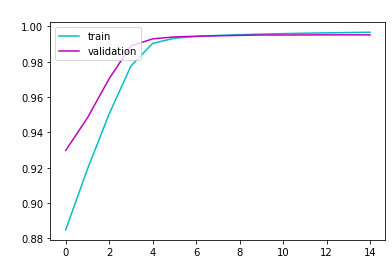

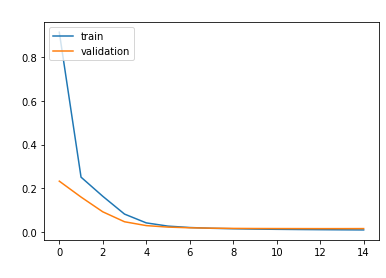

In [18]:
print(history.history.keys())
plt.axes().set(facecolor ="white")
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy').set_color('white')
plt.ylabel('accuracy').set_color('white')
plt.xlabel('epoch').set_color('white')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.axes().set(facecolor ="white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss').set_color('white')
plt.ylabel('loss').set_color('white')
plt.xlabel('epoch').set_color('white')
plt.show()

In [19]:
def generate_POS(orig_sentence):
    orig_sentence = [orig_sentence.split(" ")]
    sentence = word_tokenizer.texts_to_sequences(orig_sentence)
    sentence = pad_sequences(sentence, maxlen=max_length, truncating=trunc_type, padding=pad_type)
    
    predict_x=model.predict(sentence[0]) 
    pos = []
    for i in range(len(orig_sentence[0])):
        index = np.argmax(predict_x[i], axis=1)
        pos.append(TAGS[index[0]].upper())
        
    return list(zip(orig_sentence[0],pos))

In [20]:
pprint.pprint(TAGS)

{1: 'noun',
 2: 'verb',
 3: '.',
 4: 'adp',
 5: 'det',
 6: 'adj',
 7: 'adv',
 8: 'pron',
 9: 'conj',
 10: 'prt',
 11: 'num',
 12: 'x'}


In [21]:
sent = " ".join(X[101])
print(sent)

When he was through , the court members asked many questions , then the chairman said they would like to hear his manager 's side and talk to witnesses .


In [22]:
generate_POS(sent)

[('When', 'ADV'),
 ('he', 'PRON'),
 ('was', 'VERB'),
 ('through', 'ADP'),
 (',', '.'),
 ('the', 'DET'),
 ('court', 'NOUN'),
 ('members', 'NOUN'),
 ('asked', 'VERB'),
 ('many', 'ADJ'),
 ('questions', 'NOUN'),
 (',', '.'),
 ('then', 'ADV'),
 ('the', 'DET'),
 ('chairman', 'NOUN'),
 ('said', 'VERB'),
 ('they', 'PRON'),
 ('would', 'VERB'),
 ('like', 'ADP'),
 ('to', 'ADP'),
 ('hear', 'VERB'),
 ('his', 'DET'),
 ('manager', 'NOUN'),
 ("'s", 'PRT'),
 ('side', 'NOUN'),
 ('and', 'CONJ'),
 ('talk', 'NOUN'),
 ('to', 'ADP'),
 ('witnesses', 'NOUN'),
 ('.', '.')]

In [23]:
generate_POS("I have no money")

[('I', 'PRON'), ('have', 'VERB'), ('no', 'DET'), ('money', 'NOUN')]

In [24]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

pos_tag(word_tokenize("I have no money"), tagset='universal')

[('I', 'PRON'), ('have', 'VERB'), ('no', 'DET'), ('money', 'NOUN')]

In [25]:
generate_POS("I eat a lot of fruits")

[('I', 'PRON'),
 ('eat', 'VERB'),
 ('a', 'DET'),
 ('lot', 'NOUN'),
 ('of', 'ADP'),
 ('fruits', 'NOUN')]

In [26]:
pos_tag(word_tokenize("I eat a lot of fruits"), tagset='universal')

[('I', 'PRON'),
 ('eat', 'VERB'),
 ('a', 'DET'),
 ('lot', 'NOUN'),
 ('of', 'ADP'),
 ('fruits', 'NOUN')]